In [ ]:
# Data Exploration
## Written by Ryan Gallagher
Date 29th October 2022

In [13]:
import pandas as pd
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [14]:
# Read in data for exploration and drop unneeded columns

df = pd.read_csv("./Data/oasis_longitudinal.csv")

# Remove unneeded columns
df = df.drop(columns=['Subject ID', 'MRI ID'])

In [70]:
import requests


url = 'http://172.26.3.210:9696/predict_outcome'

client = pd.read_csv('./Data/deployment_test_data.csv')
client = client.iloc[0].to_dict()

response = requests.post(url, json=client)
result = response.json()
print(result)


{'Class': ['Nondemented'], 'probability': [[0.020773258060216904, 0.035163260996341705, 0.9440634846687317]]}


In [65]:
response

<Response [500]>

In [3]:
df['Group'].value_counts() #

# Reasonable distribution of target variables

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

## Exploratory Data Analysis

In [31]:
sns.pairplot(df, hue='Group')

/tmp/ipykernel_253/2417945102.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot:>

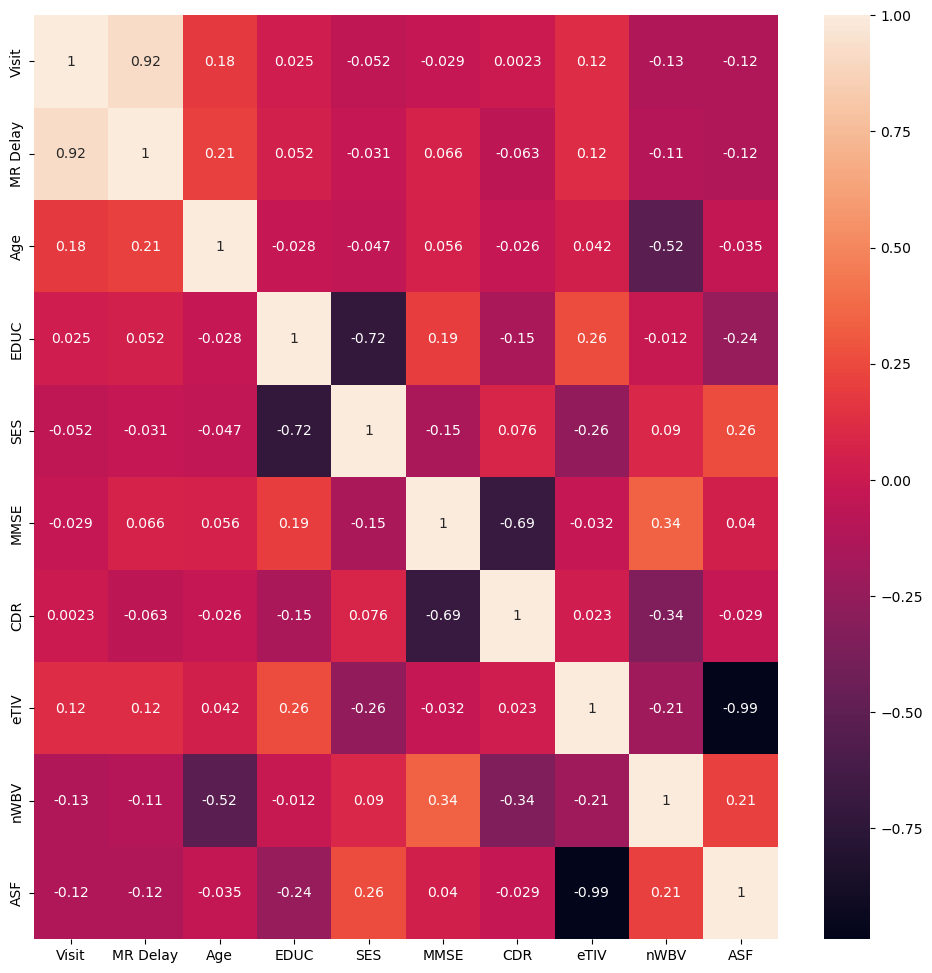

In [ ]:
# Plot Correlation Matrix
corr = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,
            #cmap = 'Blues',
            annot=True)

In [ ]:
# Check for null values
df.isna().value_counts()

# Missing values in SES and MMSE columns

Group  Visit  MR Delay  M/F    Hand   Age    EDUC   SES    MMSE   CDR    eTIV   nWBV   ASF  
False  False  False     False  False  False  False  False  False  False  False  False  False    354
                                                    True   False  False  False  False  False     17
                                                           True   False  False  False  False      2
dtype: int64

In [ ]:
df

,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


## Data Preprocessing

In [15]:
# Impute mean scores for missing values
mean_value = df['MMSE'].mean()
df['MMSE'] = df['MMSE'].fillna(value=mean_value)

mean_value = df['SES'].mean()
df['SES'] = df['SES'].fillna(value=mean_value)


#df = df.fillna(value=mean_value, inplace=True)

In [16]:
# Test Train split dataset and split into X and Y
X = df.drop(columns=['Group'])
y = df['Group']

# Split into test and train at 60/40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=1)

# now split into train and validation to give 60/20/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [ ]:
# use dict vectorizer to one hot encode the age variable for X_train, X_test and X_val

numeric = ['Visit', 'MR Delay', 'Hand', 'Age', 'EDUC', 'SES',
       'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
categoric = ['M/F']

# One hot encode the age variable
# One hot encode categoricals using a dict vectorizer
train_dict = X_train[categoric + numeric].to_dict(orient='records')
vectorizer = DictVectorizer(sparse=False)
vectorizer.fit(train_dict)
X_train = vectorizer.transform(train_dict)

# One hot encode test data for model metrics
test_dict = X_test[categoric + numeric].to_dict(orient='records')
X_test = vectorizer.transform(test_dict)

# One hot encode validation data for model metrics
val_dict = X_val[categoric + numeric].to_dict(orient='records')
X_val = vectorizer.transform(val_dict)


## Modelling

In [ ]:
# Experiment with different tree  based models. We will look at 
# 1. Classification Trees
# 2. Random Forest
# 3. XGBoost


# Classification tree
clf = DecisionTreeClassifier()
model = clf.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

print(f'ROC score for classification tree: {roc_auc_score(y_test, y_pred_probs, multi_class="ovo", average="weighted")}')
print(f'Accuracy score for classification tree is :{accuracy_score(y_test, y_pred)}')
print(f'Precision Score {precision_score(y_test, y_pred, average="weighted")}')

ROC score for classification tree: 0.7793681055534505
Accuracy score for classification tree is :0.8258928571428571
Precision Score 0.8461445648945649


In [ ]:
# Random Forest
clf = RandomForestClassifier()
model = clf.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

print(f'ROC score for classification tree: {roc_auc_score(y_test, y_pred_probs, multi_class="ovo", average="weighted")}')
print(f'Accuracy score for classification tree is :{accuracy_score(y_test, y_pred)}')
print(f'Precision Score {precision_score(y_test, y_pred, average="weighted")}')

ROC score for classification tree: 0.8869817241247737
Accuracy score for classification tree is :0.9107142857142857
Precision Score 0.9183477309476941


In [ ]:
# XGBClassifier
#use the scikit learn wrapper for XG Boost to make life easier
model = XGBClassifier() 
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 

print(f'ROC score for XG Boost: {roc_auc_score(y_test, y_pred_probs, multi_class="ovo", average="weighted")}')
print(f'Accuracy score for XG Boost is :{accuracy_score(y_test, y_pred)}')
print(f'Precision Score {precision_score(y_test, y_pred, average="weighted")}')

[19:45:55] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC score for XG Boost: 0.8869817241247737
Accuracy score for XG Boost is :0.8928571428571429
Precision Score 0.8642377417562995


/home/antihaddock/anaconda3/envs/mlbookcamp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
# Tuning a XG Boost using hyperopts library to search for best parameters

# To use XGBoost Dmatrix we need to label encode our categorical target variabe
le = LabelEncoder()
le.fit(y_train)
y_train_unlabelled = le.transform(y_train)
y_test_unlabelled = le.transform(y_test)
y_val_unlabelled = le.transform(y_val)

# Create matrix which can be used by the xgboost algorithm
train = xgb.DMatrix(X_train, label=y_train_unlabelled)
valid = xgb.DMatrix(X_val, label=y_val_unlabelled)


# Create a function that trains a XG Boost algorithm with a possible range of hyper parameters that the hyper opt library will search to find the optimal values
def objective(params):
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = model.predict(X_test) 
        roc = roc_auc_score(y_test, y_pred_probs, multi_class="ovo", average="weighted")
       
        return {'loss': roc, 'status': STATUS_OK}
    
    
# Now define the search space for the hyperparameters
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'multi:softmax',
    'num_class': 3,
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[19:52:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation-mlogloss:0.78217                       
[1]	validation-mlogloss:0.72706                       
[2]	validation-mlogloss:0.69363                       
[3]	validation-mlogloss:0.67305                       
[4]	validation-mlogloss:0.65666                       
[5]	validation-mlogloss:0.65453                       
[6]	validation-mlogloss:0.65448                       
[7]	validation-mlogloss:0.65450                       
[8]	validation-mlogloss:0.65492                       
[9]	validation-mlogloss:0.65726                       
[10]	validation-mlogloss:0.65853                      
[11]	validation-mlogloss:0.65833                      
[12]	validation-mlogloss

In [ ]:
# Call the best hyperparameters for the XGboost.
best_result

{'learning_rate': 0.37304418718359394,
 'max_depth': 23.0,
 'min_child_weight': 14.54228927574913,
 'reg_alpha': 0.07886954783579143,
 'reg_lambda': 0.27914175775055783}

## Final thoughts

It is a tie between using an XG Boost or a random forest with both returning a ROC of 0.89.

Preprocessing steps required are removing unneeded id columns, one hot encoding the column which represents gender.

I have also exported the unused test data into test csv to use as the prediction data to test in deployment.


In [17]:
X_test.to_csv('./Data/deployment_test_data.csv', index=False)

References:
    https://www.kaggle.com/code/ruslankl/dementia-prediction-w-tree-based-models